In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1) Clone the full AutoSDF repo
!git clone https://github.com/yccyenchicheng/AutoSDF.git

# 2) Move into its root so relative imports like `import utils` work
%cd AutoSDF


Cloning into 'AutoSDF'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 509 (delta 12), reused 11 (delta 11), pack-reused 484 (from 1)
Receiving objects: 100% (509/509), 58.89 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/AutoSDF


In [3]:
!pip install -q trimesh h5py einops PyMCubes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.8/336.8 kB 33.1 MB/s eta 0:00:00


In [4]:
import mcubes, sys
sys.modules['marching_cubes'] = mcubes

In [5]:
# 1) Install deps
!pip install -q fvcore iopath

# 2) Clone & install PyTorch3D
!pip install -q 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [6]:
import torch, pytorch3d
print("Torch:", torch.__version__, " CUDA:", torch.version.cuda)
print("PyTorch3D:", pytorch3d.__version__)


Torch: 2.6.0+cu124  CUDA: 12.4
PyTorch3D: 0.7.8


In [7]:
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

In [8]:
!pip install -q omegaconf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00


In [9]:
# 1) Make sure the repo root is on your path
import sys
sys.path.append("/content/AutoSDF")

# 2) Monkey‐patch configs.paths with the correct TSDF root
import configs.paths
configs.paths.dataroot = "/content/drive/MyDrive/shapenetv1/shapenetv1_tsdf32"

In [10]:
# 1) Install gdown if you don’t have it
!pip install -q gdown

# 2) Create the saved_ckpt folder
!mkdir -p /content/AutoSDF/saved_ckpt

# 3) Download all files from the Drive folder into saved_ckpt
!gdown --folder https://drive.google.com/drive/folders/1n8W_8CfQ7uZDYNrv487sd0oyhRoNLfGo \
        -O /content/AutoSDF/saved_ckpt


Retrieving folder contents
Processing file 1ZH3JMGXcO-C8Gp3iTgzmt4Ig8bpgQmCv bert2vq_epoch-145.pth
Processing file 1clfH8AfX90bIxxFw7sHYK-u0aWuahE_f pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
Processing file 1Zy-L9ADw2h4nWJG4QmaWhALk1Cpe1jw8 rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth
Processing file 1IzEXuUiE4nt8axizxZK2w7XBp5qq0RyE resnet2vq-pix3d_img-all-LR1e-4-cleanCode-pix3dMode-noBG-epoch40.pth
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ZH3JMGXcO-C8Gp3iTgzmt4Ig8bpgQmCv
From (redirected): https://drive.google.com/uc?id=1ZH3JMGXcO-C8Gp3iTgzmt4Ig8bpgQmCv&confirm=t&uuid=db513a4f-4a74-4996-b621-7ec197b16aff
To: /content/AutoSDF/saved_ckpt/bert2vq_epoch-145.pth
100% 485M/485M [00:08<00:00, 60.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1clfH8AfX90bIxxFw7sHYK-u0aWuahE_f
From (redirected): https://drive.google.com/uc?id=1clfH8AfX9

In [21]:
from utils.demo_util import get_shape_comp_opt, get_shape_comp_model
from utils.qual_util import load_resnet2vq_model

""" setup opt"""
gpu_id = 0

opt = get_shape_comp_opt(gpu_id=gpu_id)

opt.gpu_id = 0

""" setup models """
model = get_shape_comp_model(opt)

device = torch.device(f"cuda:{opt.gpu_id}" if opt.gpu_id >= 0 else "cpu")

# Move all internal index-tensors to the same device
for attr in ("x_idx_seq", "gen_order", "grid_table"):
    if hasattr(model, attr):
        setattr(model, attr, getattr(model, attr).to(device))

opt.vq_note = 'default'
model.eval()

# img marginal model
resnet2vq = load_resnet2vq_model(opt)

""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth
[*] loading state_dict with strict=False!
[*] resnet18 successfully loaded from https://download.pytorch.org/models/resnet18-f37072fd.pth.


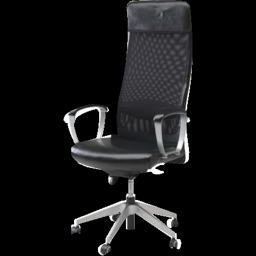

In [22]:
""" setup pix3d img dataset and image marginal model """
from utils.qual_util import load_resnet2vq_model, preprocess_img

# load and preprocess image
img_path = 'demo_data/chair_2598.jpg'
img_mask_path = 'demo_data/chair_2598_mask.png'

img_input = preprocess_img(img_path, img_mask_path)

img_name = 'demo_data/tmp.png'
vutils.save_image(img_input/2+.5, img_name)
display(ipy_image(img_name))

In [24]:
import torch
from models.rand_tf_model import RandTransformerModel

# Keep a reference to the original
_orig_set_input = RandTransformerModel.set_input

def _patched_set_input(self, input, gen_order):
    # Move everything to the same device
    device = input.device
    gen_order = gen_order.to(device)
    # These buffers may already exist, but ensure they live on GPU too
    if hasattr(self, 'x_idx_seq'):
        self.x_idx_seq = self.x_idx_seq.to(device)
    if hasattr(self, 'grid_table'):
        self.grid_table = self.grid_table.to(device)
    # Now call the original logic
    return _orig_set_input(self, input.to(device), gen_order)

# Monkey-patch the method
RandTransformerModel.set_input = _patched_set_input


In [26]:
import torch
from models.rand_tf_model import RandTransformerModel

# keep pointer to the original method
_orig_set_input = RandTransformerModel.set_input

def _patched_set_input(self, input_dict, gen_order):
    # 1) figure out the device from the first tensor in the input dict
    for v in input_dict.values():
        if torch.is_tensor(v):
            device = v.device
            break
    else:
        device = torch.device("cpu")

    # 2) move all tensors in input_dict to that device
    for k,v in list(input_dict.items()):
        if torch.is_tensor(v):
            input_dict[k] = v.to(device)

    # 3) move gen_order and internal buffers to the same device
    gen_order = gen_order.to(device)
    if hasattr(self, 'x_idx_seq'):
        self.x_idx_seq = self.x_idx_seq.to(device)
    if hasattr(self, 'grid_table'):
        self.grid_table = self.grid_table.to(device)

    # 4) call the original logic with everything on the right device
    return _orig_set_input(self, input_dict, gen_order)

# apply the patch
RandTransformerModel.set_input = _patched_set_input


In [27]:
""" single-view reconstruction """
nimgs = 3
topk = 10
alpha = 0.7

single_view_recon = model.single_view_recon(img_input, resnet2vq, bs=nimgs, topk=topk, alpha=alpha)

gen_mesh = sdf_to_mesh(single_view_recon)

# save as gif
res_dir = 'results'
gen_gif_name = f'{res_dir}/single-view-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

for name in [img_name, gen_gif_name]:
    display(ipy_image(name))

AttributeError: 'NoneType' object has no attribute 'to'